In [21]:
import bpy
from IPython.display import display, Image

def fresh_scene():
    # Deselect all objects
    bpy.ops.object.select_all(action='DESELECT')
    # Select all objects except cameras
    for obj in bpy.context.scene.objects:
        if  obj.type != 'CAMERA':
            obj.select_set(True)
        else:
            obj.select_set(False)
    bpy.ops.object.delete()
    
    # add light
    bpy.ops.object.light_add(type='SUN')
    sun = bpy.context.object

    sun.location = (0, 0, 0)
    from math import radians
    sun.rotation_euler = (radians(204), radians(-133), radians(-67))
    sun.data.energy = 5  


def render_result():
    bpy.ops.render.render()
    bpy.data.images['Render Result'].save_render(filepath="img.png")
    display(Image(filename="img.png"))

bpy.context.scene.render.resolution_x = 500
bpy.context.scene.render.resolution_y = 200

In [32]:
import pandas as pd
url = 'https://raw.githubusercontent.com/kolibril13/ipydrop/refs/heads/main/dino.csv'
df = pd.read_csv(url)
df.head()

,x,y
0,55.3846,97.1795
1,51.5385,96.0256
2,46.1538,94.4872
3,42.8205,91.4103
4,40.7692,88.3333


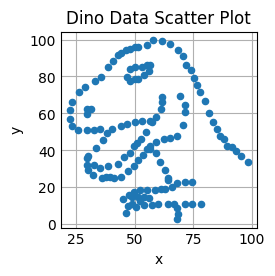

In [34]:
df.plot.scatter(x='x', y='y', title='Dino Data Scatter Plot');

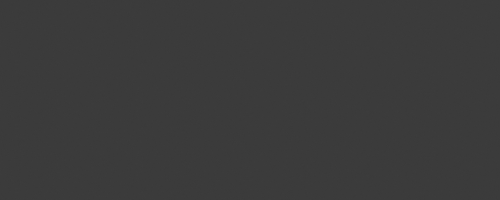

In [28]:
fresh_scene()
import math
camera = bpy.context.scene.camera
camera.location = (0.0, 0.0, 50.0)
camera.rotation_euler = (math.radians(90), 0, 0)


for (vx, vy) in zip(x,y):    
    bpy.ops.mesh.primitive_uv_sphere_add(radius=0.1, location=(vx, vy, 0))
    
render_result()

In [29]:
# temp
bpy.ops.wm.save_as_mainfile(filepath="deno.blend")

Info: Total files 0 | Changed 0 | Failed 0
Info: Saved "deno.blend"


{'FINISHED'}